# Dataset

https://www.kaggle.com/c/severstal-steel-defect-detection

about dataset:
Type of defects found in steel manufacturing. Images are named with a unique ImageId. You must segment and classify the defects in the test set.

Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image you must segment defects of each class (ClassId = [1, 2, 3, 4]).

# Import

In [1]:
import os
from pathlib import Path
# from tqdm import tqdm
import json

import numpy as np # linear algebra
import pandas as pd
#pd.set_option("display.max_rows", 101)
import math

import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 10
import seaborn as sns
from PIL import Image

from collections import Counter
from collections import defaultdict

from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# List all physical devices available for TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs: ", physical_devices)

# Optional: Set memory growth for GPUs (this prevents TensorFlow from allocating all GPU memory at once)
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
! python --version

Python 3.9.19


In [6]:
!nvidia-smi

Fri Oct  4 00:13:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:07:00.0  On |                  N/A |
|  0%   47C    P8             11W /   75W |     346MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
train_df = pd.read_csv('severstal-steel-defect-detection/train.csv')

In [8]:
DIRin1 = "severstal-steel-defect-detection"
print("DIRin1 =", os.listdir(DIRin1))
DIRtrain = os.path.join(DIRin1,"train_images")
DIRtest = os.path.join(DIRin1,"test_images")

DIRin2 = "defect-detection-training"
print("DIRin2 =", os.listdir(DIRin2))
# save path
weights_path = os.path.join(DIRin2,"DefectDetection.h5")
history_path = os.path.join(DIRin2,"DefectDetection_history.csv")

print("Num of Train img\t:",len(os.listdir(DIRtrain)))
print("Num of Test img\t\t:",len(os.listdir(DIRtest)))

DIRin1 = ['sample_submission.csv', 'test_images', 'train.csv', 'train_images']
DIRin2 = []
Num of Train img	: 12568
Num of Test img		: 5506


# EDA

In [9]:
##### Training conditions ##### 
batch_size = 8

NoTRAIN = True    # True:No further training, use pre-learned weights
RESUME = False    # True:Resume Training, False:Start from the beginning

if RESUME:
    initial_epoch = 50    # initial_epoch when training resumes
else:
    initial_epoch = 0
# epochs = initial_epoch + 10
epochs = 200
steps_per_epoch = len(os.listdir(DIRtrain))//batch_size

In [10]:
steps_per_epoch

1571

In [11]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [13]:
train_df.isnull().sum()

ImageId          0
ClassId          0
EncodedPixels    0
dtype: int64

(1600, 256)


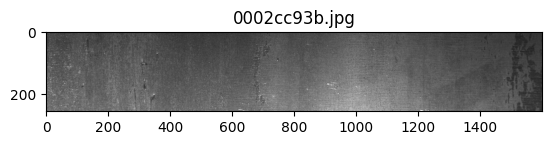

(1600, 256)


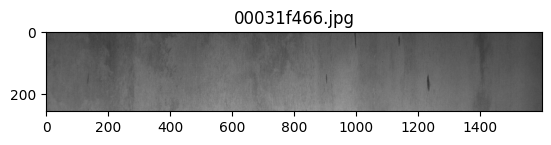

(1600, 256)


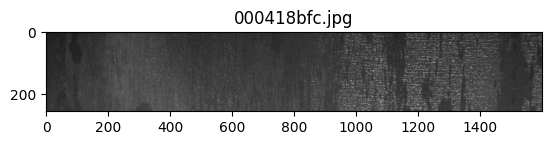

(1600, 256)


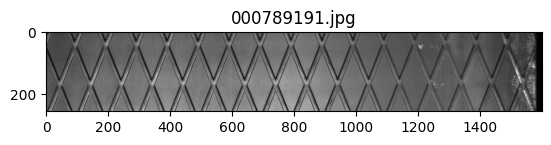

(1600, 256)


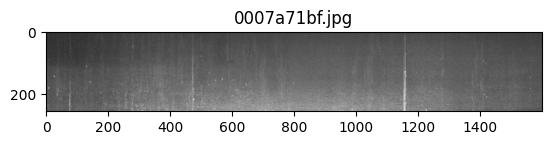

In [14]:
def plot_sample_images(image_dir, num_samples=5):
    sample_images = os.listdir(image_dir)[:num_samples]
    for image_file in sample_images:
        img = Image.open(os.path.join(image_dir, image_file))
        print(img.size)
        plt.imshow(img)
        plt.title(image_file)
        plt.show()

# Plot sample images
plot_sample_images('severstal-steel-defect-detection/train_images')

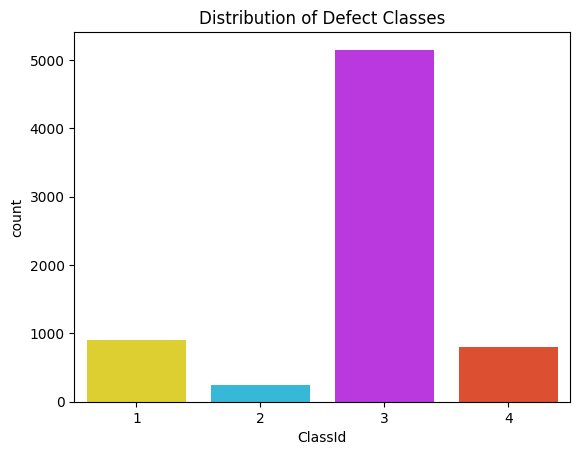

In [15]:
# Plot defect in each classes
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]
sns_palet = []
for color in palet:
    sns_palet.append((color[0]/255, color[1]/255, color[2]/255))
    
sns.countplot(data=train_df, x='ClassId',palette=sns_palet)
plt.title('Distribution of Defect Classes')
plt.show()

In [16]:
# Transform class to column
train_df = train_df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)
#train_df.reset_index()
train_df.head(10)

ClassId,1,2,3,4,defects
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1
0025bde0c.jpg,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...,2
002af848d.jpg,NaN,NaN,NaN,290800 6 291055 13 291311 15 291566 18 291822 ...,1
002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,NaN,NaN,2
0030401a5.jpg,NaN,NaN,NaN,186833 1 187089 3 187344 6 187600 7 187855 10 ...,1


In [17]:
# Presence of defects in each images
no_defects_num = np.sum(train_df['defects'] == 0)
defects_num = len(train_df) - no_defects_num
print("no_defect imgs \t:", no_defects_num)
print("defects imgs \t:", defects_num)

no_defect imgs 	: 0
defects imgs 	: 6666


In [18]:
# Number of defects for each class
class_defects = len(train_df) - train_df.isnull().sum()
class_defects[:4]

ClassId
1     897
2     247
3    5150
4     801
dtype: int64

In [19]:
# # check images size
# train_size = defaultdict(int)
# test_size = defaultdict(int)

# for fPath in Path(DIRtrain).iterdir():
#     img = Image.open(fPath)
#     train_size[img.size] += 1
# for fPath in Path(DIRtest).iterdir():
#     img = Image.open(fPath)
#     test_size[img.size] += 1
    
# print("train_img_size :",train_size)
# print("test_img_size  :",test_size)

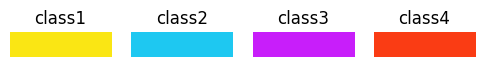

In [20]:
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class{}".format(i+1))

plt.show()

In [21]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):    # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [22]:
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [23]:
def show_mask_image(row_id, contour = True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:,:,ch]==255] = palet[ch]
        
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title(name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [24]:
# classify defects
idx_class_1 = list(filter(lambda r:pd.notna(train_df.iloc[r,0]) and pd.isna(train_df.iloc[r,1]) and pd.isna(train_df.iloc[r,2]) and pd.isna(train_df.iloc[r,3]), range(len(train_df))))
idx_class_2 = list(filter(lambda r:pd.notna(train_df.iloc[r,1]) and pd.isna(train_df.iloc[r,0]) and pd.isna(train_df.iloc[r,2]) and pd.isna(train_df.iloc[r,3]), range(len(train_df))))
idx_class_3 = list(filter(lambda r:pd.notna(train_df.iloc[r,2]) and pd.isna(train_df.iloc[r,0]) and pd.isna(train_df.iloc[r,1]) and pd.isna(train_df.iloc[r,3]), range(len(train_df))))
idx_class_4 = list(filter(lambda r:pd.notna(train_df.iloc[r,3]) and pd.isna(train_df.iloc[r,0]) and pd.isna(train_df.iloc[r,1]) and pd.isna(train_df.iloc[r,2]), range(len(train_df))))
# Number of defects class
idx_1_defect = list(filter(lambda r:train_df.iloc[r,4] == 1, range(len(train_df))))
idx_2_defect = list(filter(lambda r:train_df.iloc[r,4] == 2, range(len(train_df))))
idx_3_defect = list(filter(lambda r:train_df.iloc[r,4] == 3, range(len(train_df))))
idx_4_defect = list(filter(lambda r:train_df.iloc[r,4] == 4, range(len(train_df))))

print(f'image with class 1 defect {len(idx_class_1)} images')
print(f'image with class 2 defect {len(idx_class_2)} images')
print(f'image with class 3 defect {len(idx_class_3)} images')
print(f'image with class 4 defect {len(idx_class_4)} images')
print('\n')
print(f'image with 1 defect{len(idx_1_defect)}')
print(f'image with 2 defects{len(idx_2_defect)}')
print(f'image with 3 defects{len(idx_3_defect)}')
print(f'image with 4 defects{len(idx_4_defect)}')

image with class 1 defect 769 images
image with class 2 defect 195 images
image with class 3 defect 4759 images
image with class 4 defect 516 images


image with 1 defect6239
image with 2 defects425
image with 3 defects2
image with 4 defects0


## Visualize Image with 1 defect

### Class 1 defect

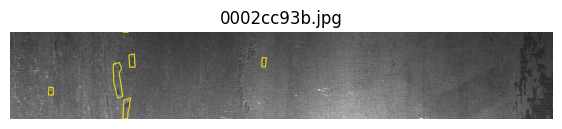

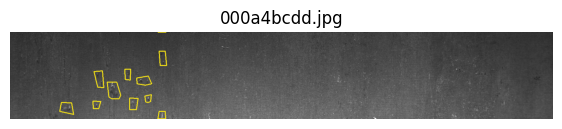

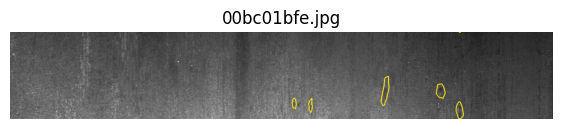

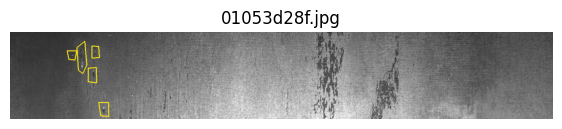

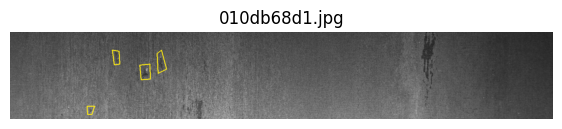

In [25]:
for i in idx_class_1[:5]:
    show_mask_image(i)

### Class 2 Defect

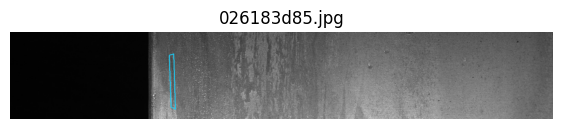

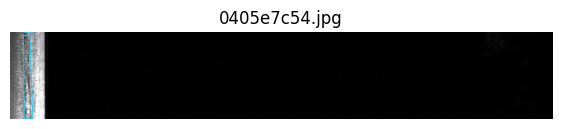

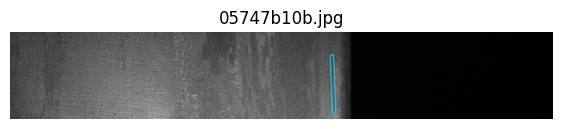

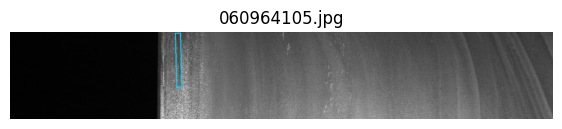

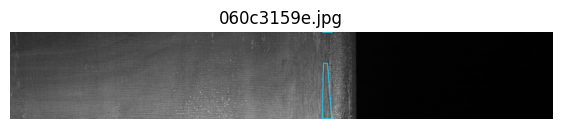

In [26]:
for i in idx_class_2[:5]:
    show_mask_image(i)

### Class 3 Defect

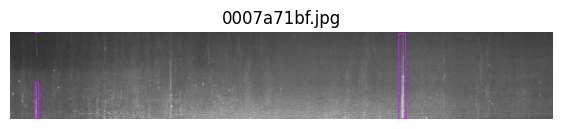

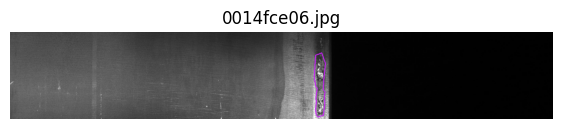

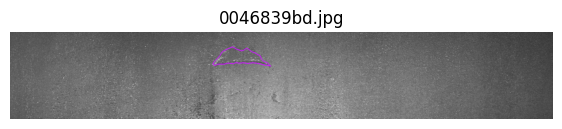

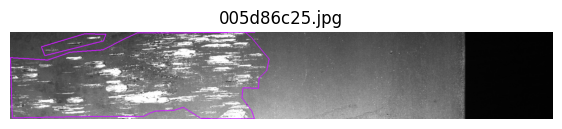

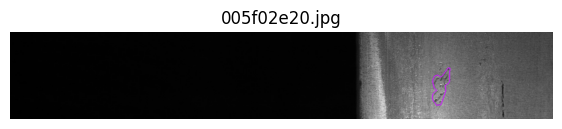

In [27]:
for i in idx_class_3[:5]:
    show_mask_image(i)

### Class 4 Defect

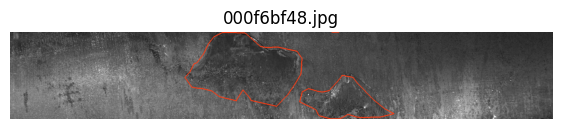

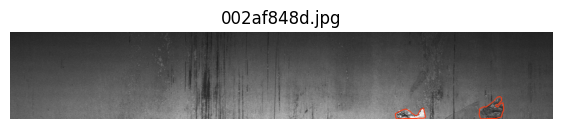

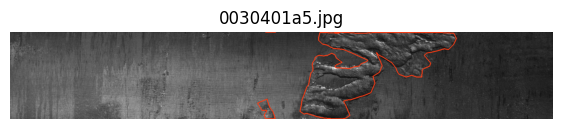

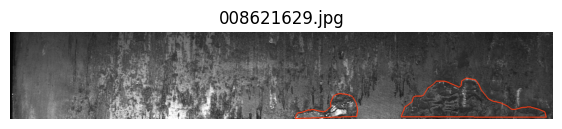

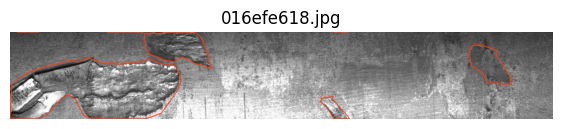

In [28]:
for i in idx_class_4[:5]:
    show_mask_image(i)

## Visualize Image with Multiclass Defect

### 2 Defects

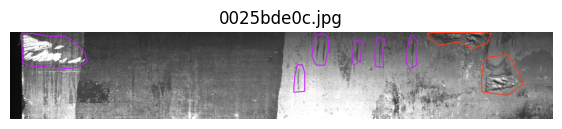

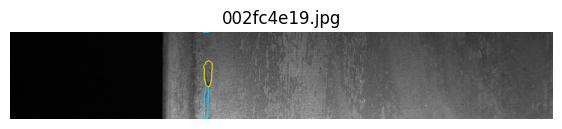

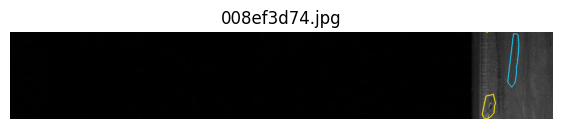

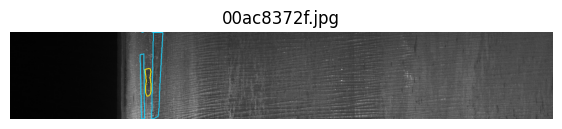

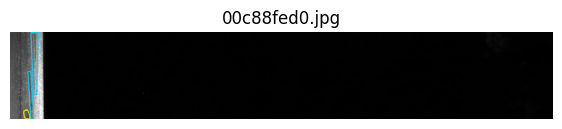

In [29]:
for i in idx_2_defect[:5]:
    show_mask_image(i)

In [30]:
# checking image with 2 defects
idx_12_defect = list(filter(lambda r:pd.notna(train_df.iloc[r,0]) and pd.notna(train_df.iloc[r,1]) and pd.isna(train_df.iloc[r,2]) and pd.isna(train_df.iloc[r,3]), range(len(train_df))))
idx_13_defect = list(filter(lambda r:pd.notna(train_df.iloc[r,0]) and pd.isna(train_df.iloc[r,1]) and pd.notna(train_df.iloc[r,2]) and pd.isna(train_df.iloc[r,3]), range(len(train_df))))
idx_14_defect = list(filter(lambda r:pd.notna(train_df.iloc[r,0]) and pd.isna(train_df.iloc[r,1]) and pd.isna(train_df.iloc[r,2]) and pd.notna(train_df.iloc[r,3]), range(len(train_df))))
idx_23_defect = list(filter(lambda r:pd.isna(train_df.iloc[r,0]) and pd.notna(train_df.iloc[r,1]) and pd.notna(train_df.iloc[r,2]) and pd.isna(train_df.iloc[r,3]), range(len(train_df))))
idx_24_defect = list(filter(lambda r:pd.isna(train_df.iloc[r,0]) and pd.notna(train_df.iloc[r,1]) and pd.isna(train_df.iloc[r,2]) and pd.notna(train_df.iloc[r,3]), range(len(train_df))))
idx_34_defect = list(filter(lambda r:pd.isna(train_df.iloc[r,0]) and pd.isna(train_df.iloc[r,1]) and pd.notna(train_df.iloc[r,2]) and pd.notna(train_df.iloc[r,3]), range(len(train_df))))

print(f'defect1 & 2: {len(idx_12_defect)} images')
print(f'defect1 & 3: {len(idx_13_defect)} images')
print(f'defect1 & 4: {len(idx_14_defect)} images')
print(f'defect2 & 3: {len(idx_23_defect)} images')
print(f'defect2 & 4: {len(idx_24_defect)} images')
print(f'defect3 & 4: {len(idx_34_defect)} images')
print(f'total 2 defects: {len(idx_12_defect) + len(idx_13_defect) + len(idx_14_defect) + len(idx_23_defect) + len(idx_24_defect) + len(idx_34_defect)}')

defect1 & 2: 35 images
defect1 & 3: 91 images
defect1 & 4: 0 images
defect2 & 3: 14 images
defect2 & 4: 1 images
defect3 & 4: 284 images
total 2 defects: 425


### 3 Defects (class 1, 2, & 3 defects)

In [31]:
train_df[train_df['defects'] > 2]

ClassId,1,2,3,4,defects
ImageId,,,,,
db4867ee8.jpg,349941 2 350194 6 350447 11 350700 15 350953 1...,354411 17 354634 50 354857 82 355096 99 355351...,233729 3008 236801 64,NaN,3
ef24da2ba.jpg,366699 32 366955 32 367210 33 367466 33 367722...,366338 17 366594 50 366850 82 367106 99 367362...,178369 64 178498 191 178690 255 178946 255 179...,NaN,3


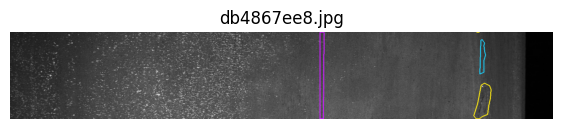

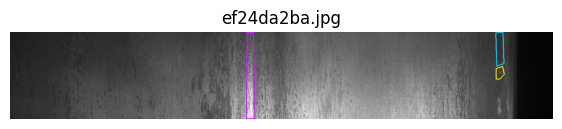

In [32]:
for i in idx_3_defect:
    show_mask_image(i)

# U-Net Model

In [33]:
input_shape = (256, 1600, 1)
inputs = Input(input_shape)

reg_strength = 1e-4

c1 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)) (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

# Load pre-traind weights
if (NoTRAIN or RESUME) and os.path.exists(weights_path):
    model.load_weights(weights_path)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1600,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 1600, 8  80          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 1600, 8  584         ['conv2d[0][0]']                 
                                )                                                             

In [34]:
# def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) \
#             / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

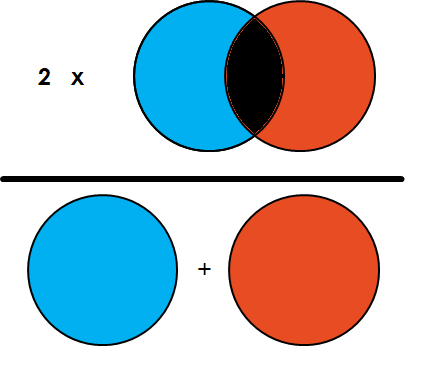

In [35]:
def dice_coefficient(y_true, y_pred):
    """
    Compute the Dice coefficient between y_true and y_pred.
    
    Args:
    - y_true: Ground truth mask
    - y_pred: Predicted mask
    
    Returns:
    - dice_coeff: The computed Dice coefficient.
    """
    
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Explicitly cast to float32
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)
    
    # Compute the intersection and the sum of the two masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    # Compute Dice coefficient
    dice_coeff = (2. * intersection) / union
    
    return dice_coeff

In [36]:
optimizer = Adam(learning_rate = 5e-4)
model.compile(optimizer, 'binary_crossentropy', metrics=[dice_coefficient])

In [37]:
# # Train Data Generator
# def Xy_generator(ids, batch_size):
#     Xs = []; ys = []
#     while True:
#         for i in ids:
#             name, mask = make_mask(i)
#             img = cv2.imread(os.path.join(DIRtrain, name),
#                              cv2.IMREAD_GRAYSCALE)
#             img = img[..., np.newaxis]    # Add channel axis
#             img = img / 255.           # 0～1
#             mask = mask / 255.         # 0～1
#             Xs.append(img); ys.append(mask)
#             if len(Xs) == batch_size:
#                 X = np.array(Xs); y = np.array(ys)
#                 Xs = []; ys = []
#                 yield (X, y)

In [38]:
!pip install albumentations

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
    --------------------------------------- 0.5/38.8 MB 2.8 MB/s eta 0:00:14
    --------------------------------------- 0.8/38.8 MB 2.6 MB/s eta 0:00:15
   - -------------------------------------- 1.0/38.8 MB 1.9 MB/s eta 0:00:21
   - -------------------------------------- 1.8/38.8 MB 2.2 MB/s eta 0:00:17
   -- ------------------------------------- 2.4/38.8 MB 2.2 MB/s eta 0:00:17
   -- ------------------------------------- 2.6/38.8 MB 2.3 MB/s eta 0:00:16
   --- ------------------------------------ 3.1/38.8 MB 2.3 MB/s eta 0:00:16
   --- ------------------------------------ 3.7/38.8 MB 2.3 MB/s eta 0:00:16
   ---- ----------------------------------- 4.2/38.8 MB 2.3 MB/s eta 0:00:16
   ---- ----------------------------------- 4.5/38.8 MB 2.3 MB/s eta 0:00:16
   ----- ---------------------------------- 5.0/38.8 MB 2.3 MB/s eta 0:00:15
   ----- ---------------------------------- 5.2/38.8 MB 2.3 MB/s eta 0:00:15
   ---

In [47]:
import albumentations as A

In [54]:
# Define the augmentation pipeline
def get_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),       # 50% chance to flip horizontally
        A.VerticalFlip(p=0.5),         # 50% chance to flip vertically
        A.Rotate(limit=20, p=0.5),     # Rotate image by -20 to +20 degrees
        A.RandomBrightnessContrast(p=0.5),  # Randomly adjust brightness and contrast
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),  # Shift, scale, rotate
        A.ElasticTransform(p=0.2),     # Apply elastic transformation with 20% probability
        A.RandomCrop(height=256, width=1600, p=1.0),  # Crop image to 256x256
    ], additional_targets={'mask': 'mask'})  # Ensure the same augmentations are applied to the mask

# Modified generator with Albumentations
def Xy_generator(ids, batch_size, augment=False, shuffle=True):
    Xs = []; ys = []
    
    if shuffle:
        np.random.shuffle(ids)  # Shuffle the ids before starting

    augmentation_pipeline = get_augmentation_pipeline()  # Get the augmentation pipeline

    while True:
        for i in ids:
            # Load image and mask
            name, mask = make_mask(i)  # Assuming make_mask returns a filename and mask array
            img_path = os.path.join(DIRtrain, name)
            
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = img[..., np.newaxis]    # Add channel axis for grayscale images
                img = img / 255.0             # Normalize image pixel values to range 0-1
                mask = mask / 255.0           # Normalize mask pixel values to range 0-1
            except Exception as e:
                print(f"Error reading image or mask for {name}: {e}")
                continue  # Skip this image if there is an error
            
            # Data Augmentation using Albumentations (Optional)
            if augment:
                augmented = augmentation_pipeline(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            Xs.append(img)
            ys.append(mask)
            
            # Yield batch when batch size is reached
            if len(Xs) == batch_size:
                X = np.array(Xs)
                y = np.array(ys)
                Xs = []; ys = []  # Reset lists for next batch
                yield (X, y)
        
        # Reshuffle ids after each epoch if shuffle is enabled
        if shuffle:
            np.random.shuffle(ids)

In [55]:
# # Train Data
# train_ids, val_ids = train_test_split(range(len(train_df)), test_size=0.2)
# train_gen = Xy_generator(train_ids, batch_size)
# val_gen = Xy_generator(val_ids, batch_size)

In [56]:
# Train Data
train_ids, val_ids = train_test_split(range(len(train_df)), test_size=0.2)

# Create the training generator
train_gen = Xy_generator(train_ids, batch_size=batch_size, augment=True, shuffle=True)

# Create the validation generator without augmentation
val_gen = Xy_generator(val_ids, batch_size=batch_size, augment=False, shuffle=False)


In [51]:
train_gen

<generator object Xy_generator at 0x0000013FD1016E40>

In [57]:
# Callback
checkpoint = ModelCheckpoint("DefectDetection.keras", monitor='val_dice_coef',
                             verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Fit
history = model.fit(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              initial_epoch=initial_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps = len(val_ids)//batch_size,
                              verbose=2,
                              shuffle=True,
                              callbacks=callbacks_list)

Epoch 1/200
1571/1571 - 739s - loss: 0.0930 - dice_coefficient: 0.0644 - val_loss: 0.0592 - val_dice_coefficient: 0.0932 - 739s/epoch - 471ms/step
Epoch 2/200
1571/1571 - 653s - loss: 0.0571 - dice_coefficient: 0.1417 - val_loss: 0.0498 - val_dice_coefficient: 0.1988 - 653s/epoch - 416ms/step
Epoch 3/200
1571/1571 - 656s - loss: 0.0518 - dice_coefficient: 0.2054 - val_loss: 0.0476 - val_dice_coefficient: 0.2285 - 656s/epoch - 417ms/step
Epoch 4/200
1571/1571 - 656s - loss: 0.0487 - dice_coefficient: 0.2366 - val_loss: 0.0454 - val_dice_coefficient: 0.2594 - 656s/epoch - 418ms/step
Epoch 5/200
1571/1571 - 656s - loss: 0.0475 - dice_coefficient: 0.2478 - val_loss: 0.0486 - val_dice_coefficient: 0.2591 - 656s/epoch - 418ms/step
Epoch 6/200
1571/1571 - 655s - loss: 0.0468 - dice_coefficient: 0.2543 - val_loss: 0.0432 - val_dice_coefficient: 0.2588 - 655s/epoch - 417ms/step
Epoch 7/200
1571/1571 - 656s - loss: 0.0456 - dice_coefficient: 0.2686 - val_loss: 0.0437 - val_dice_coefficient: 0.26

In [ ]:
# history = pd.read_csv('history.csv')

In [ ]:
# history

In [ ]:
# plt.plot(history['dice_coefficient'], label = 'test_dice_coefficient')
# plt.plot(history['val_dice_coefficient'], label = 'val_dice_coefficient')
# plt.legend()
# plt.ylim(0, 1)
# plt.xlabel('epoch')
# plt.show()

In [ ]:
# plt.plot(history['loss'], label = 'test_loss')
# plt.plot(history['val_loss'], label = 'val_loss')
# plt.legend()
# plt.xlabel('epoch')
# plt.show()

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coefficient', 'val_dice_coefficient']].plot()

In [ ]:
model.save('DefectDetection5.h5')